In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
import fastai.basics as fai
import fastai.vision as fv
from pathlib import Path
from shutil import copyfile
import random
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision.utils as utils
import PIL
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm_notebook as tqdm
import gc
import matplotlib.pyplot as plt
import numpy as np


In [4]:
path_good   = Path("test/")
path_crappy = Path("sketches_test/")

In [5]:
def imagen_bonita(x): 
    return path_good/x.relative_to(path_crappy)

def load_data(img_size, batch_size, amount=1.):
    data = (fv.ImageImageList.from_folder(path_crappy)
            .filter_by_rand(amount)
            .random_split_by_pct(0.3)
            .label_from_func(imagen_bonita)
            .databunch(bs=batch_size)
            .normalize(fv.imagenet_stats, do_y=True))
    data.c = 3
    return data

In [6]:
def l1_loss_flat(a,b):
    return F.l1_loss(a.squeeze(), b.squeeze())

In [7]:
def create_learner(data):
    return fv.unet_learner(data, fv.models.resnet34, 
                           blur=True, norm_type=fai.NormType.Weight, 
                           self_attention=True, y_range=(-3.,3.), 
                           loss_func=l1_loss_flat, wd=1e-2)

In [8]:
data = load_data(178, 8, 1)
learn = create_learner(data)

In [9]:
iteration = 'A'
def save_model(img_size, suffix=""):
    path = Path(f'sketches_test/models/{iteration}')
    path.mkdir(exist_ok=True)
    torch.save(learn.model.state_dict(), path/f'{img_size}-{suffix}.pth')
def load_model(img_size, suffix=""):
    learn.model.load_state_dict(torch.load(f'sketches_test/models/{iteration}/{img_size}-{suffix}.pth'))

In [10]:
def show_tensor_as_image(tensor, ncols=5, figsize=12, title = ""):
    plt.figure(figsize=(figsize,figsize))
    plt.axis("off")
    plt.title(title)
    plt.imshow(np.transpose(utils.make_grid(tensor.detach().cpu()[:ncols*ncols], nrow=ncols, padding=2, normalize=True).cpu(),(1,2,0)))

def compare_manually():
    data = load_data(384,4,amount=0.01)
    gc.collect()
    imgs,targs = next(iter(data.valid_dl))
    learn.model.eval();
    gen_imgs = learn.model(imgs)
    show_tensor_as_image(imgs, ncols=1)
    show_tensor_as_image(gen_imgs, ncols=1)
    show_tensor_as_image(targs, ncols=1)


In [ ]:
compare_manually()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-04


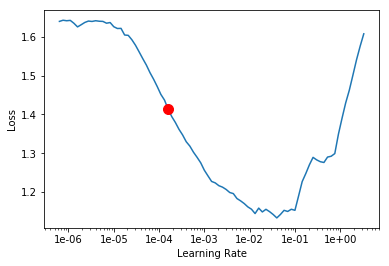

In [11]:
learn.lr_find(); learn.recorder.plot()

In [12]:
gc.collect()

7628

In [13]:
learn.fit_one_cycle(8, max_lr = 3e-3)

In [14]:
learn.save('stage-1_loss-30')

In [ ]:
#learn.load('stage-1_loss-30')

In [15]:
learn.lr_find(); learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07


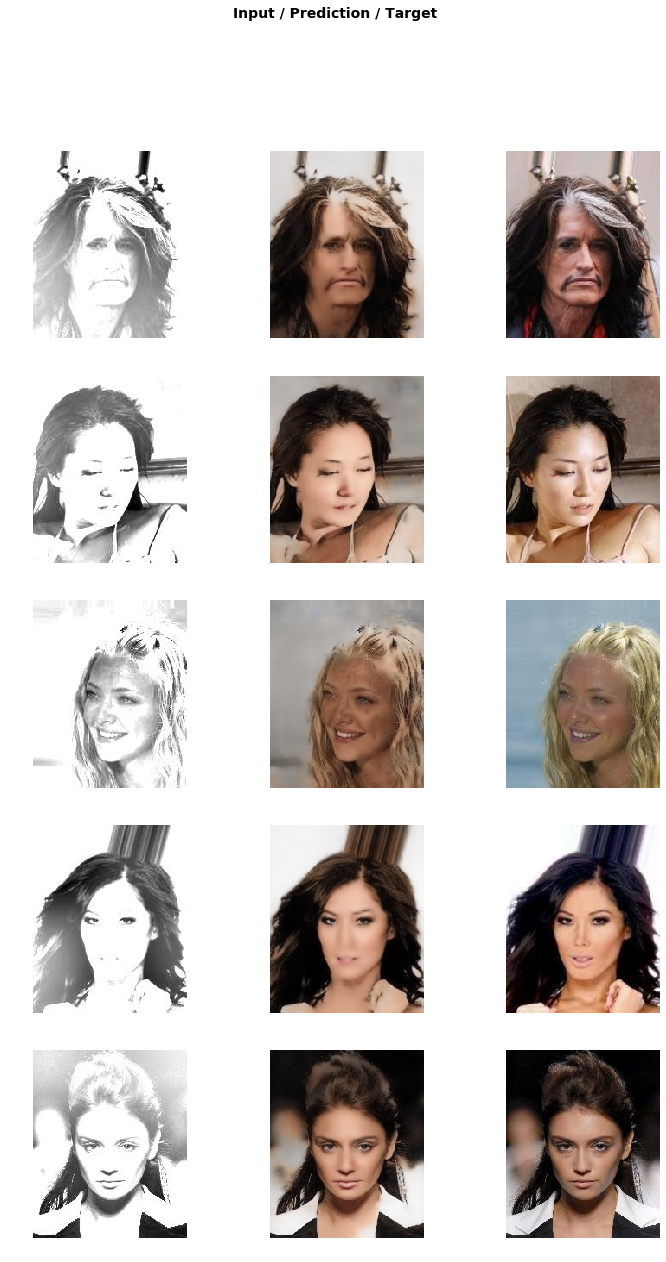

In [16]:
learn.show_results(3)

In [18]:
sizes = [96,128,160,178]
AS = {96:0.15, 128:0.2, 160:0.2, 178:0.3}
BS = {96:24, 128:16, 160:8, 178:4}

for size in sizes:
    lr = 2e-4
    for freeze in range(1, len(learn.layer_groups)+1):
        learn.data = load_data(size, BS[size], AS[size])
        learn.freeze_to(-freeze)
        print(f"{size} at freeze level {freeze}")
        gc.collect()
        torch.cuda.empty_cache()
        learn.fit_one_cycle(1, max_lr=slice(lr/64,lr))
        save_model(size,freeze) 
        lr *= 0.8

96 at freeze level 1


96 at freeze level 2


96 at freeze level 3


128 at freeze level 1


128 at freeze level 2


128 at freeze level 3


160 at freeze level 1


160 at freeze level 2


160 at freeze level 3


178 at freeze level 1


178 at freeze level 2


178 at freeze level 3


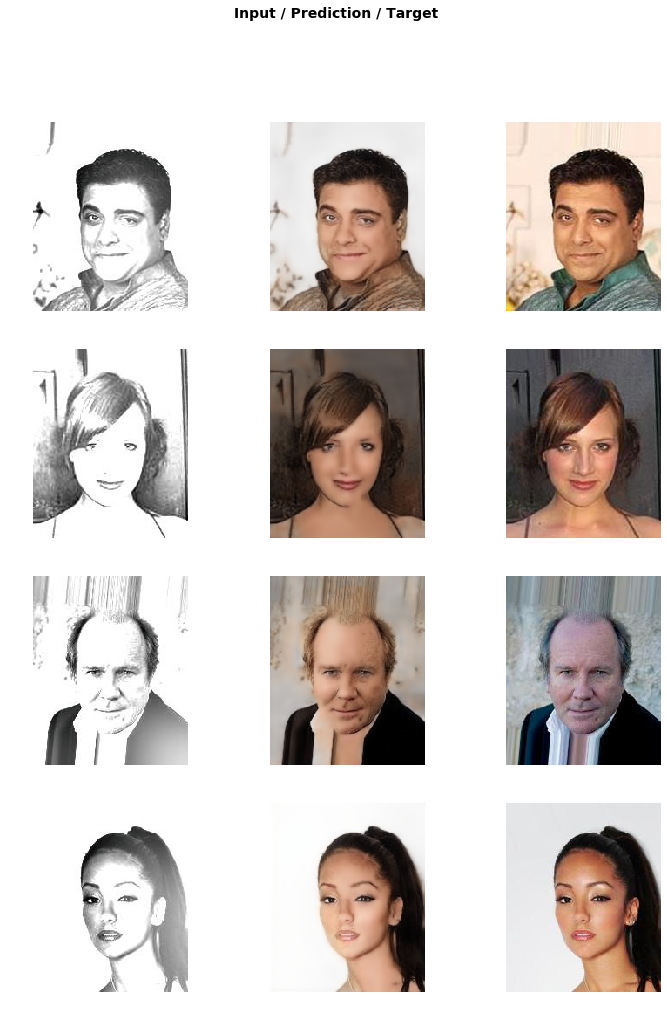

In [19]:
learn.show_results(rows=4)

In [33]:
vgg = torchvision.models.vgg16_bn(pretrained=True).eval()
fai.requires_grad(vgg, False)

In [34]:
good_blocks = [i-1 for i,o in enumerate(vgg.children()) if isinstance(o,nn.MaxPool2d)]

In [37]:
good_blocks[2:]

[22, 32, 42]

In [35]:
from PerceptualLoss import *

In [42]:
learn.loss_func = PerceptualLoss(vgg, good_blocks[2:], weights = [5,12,2]).cuda()

In [43]:
learn.data = load_data(178, 8, 1)

In [44]:
sizes = [96,128,160,178]
AS = {96:0.2, 128:0.3, 160:0.4, 178:0.5}
BS = {96:24, 128:16, 160:8, 178:4}

for size in sizes:
    lr = 1e-3
    for freeze in range(1, len(learn.layer_groups)+1):
        learn.data = load_data(size, BS[size], AS[size])
        learn.freeze_to(-freeze)
        print(f"{size} at freeze level {freeze}")
        gc.collect()
        torch.cuda.empty_cache()
        learn.fit_one_cycle(1, max_lr=slice(lr/64,lr))
        save_model(size,f'perceptual-{freeze+1}') 
        lr *= 0.8


96 at freeze level 1


96 at freeze level 2


96 at freeze level 3


128 at freeze level 1


128 at freeze level 2


128 at freeze level 3


160 at freeze level 1


160 at freeze level 2


160 at freeze level 3


178 at freeze level 1


178 at freeze level 2


178 at freeze level 3


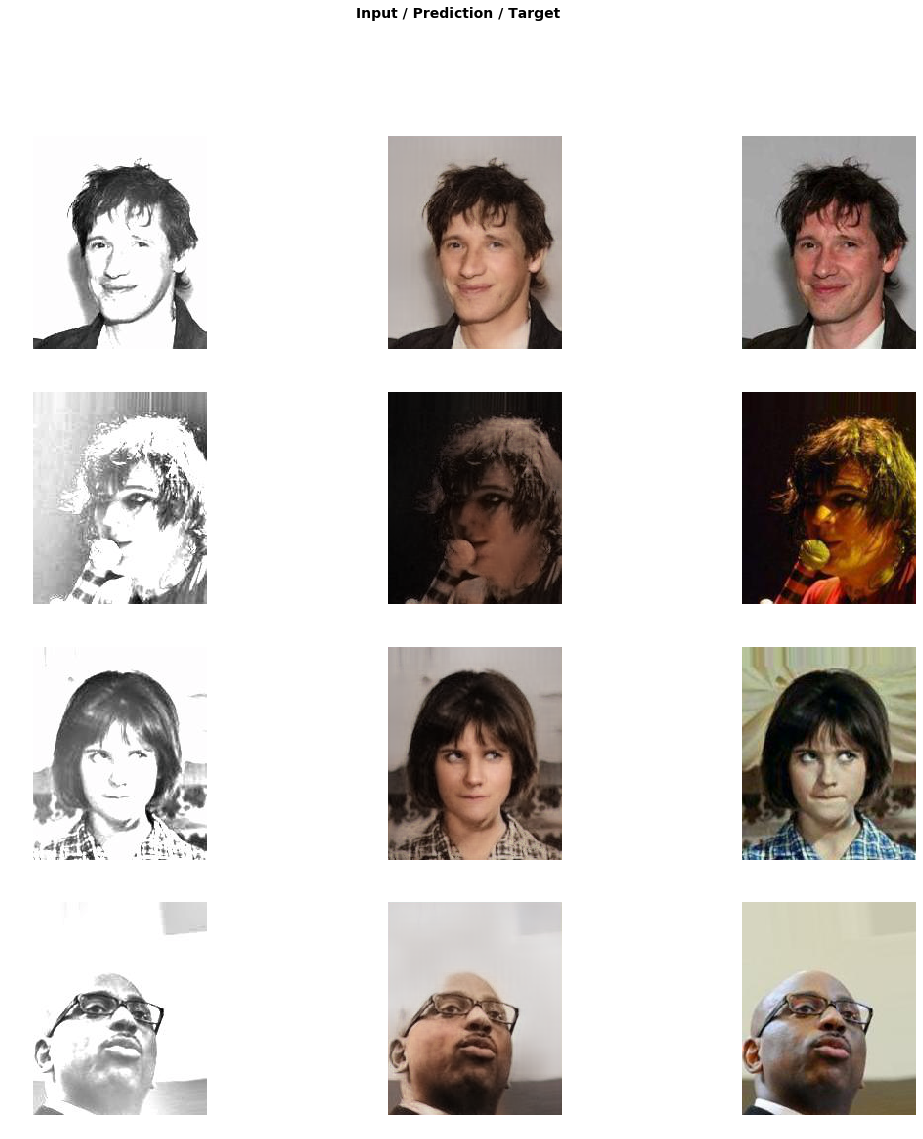

In [45]:
learn.show_results(rows=4,figsize=(18,18))

In [46]:
gc.collect()
torch.cuda.empty_cache()

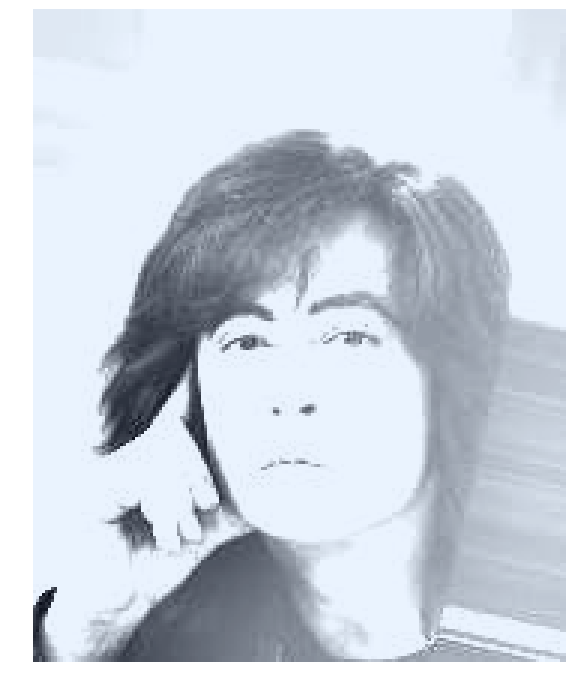

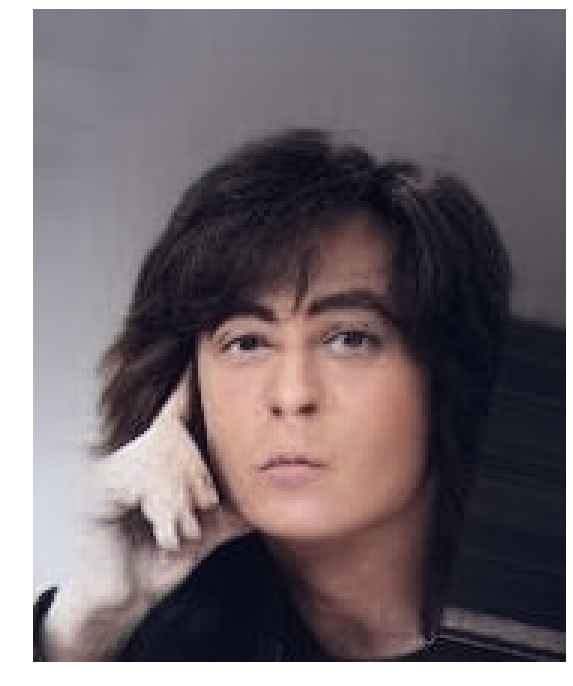

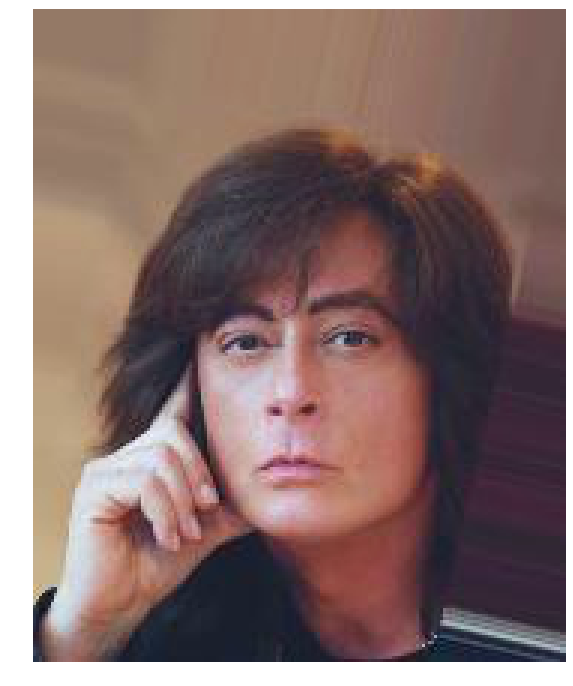

In [47]:
compare_manually()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-06


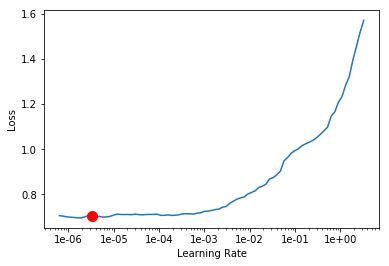

In [48]:
learn.lr_find(); learn.recorder.plot()

In [49]:
num_cycles = 3
for cycle in range(num_cycles):
    gc.collect()
    learn.data = load_data(178, 8, 1)
    learn.fit_one_cycle(1,slice(2e-4,3e-3),pct_start=0.8)
    save_model(178,f'shippuden-{cycle}')

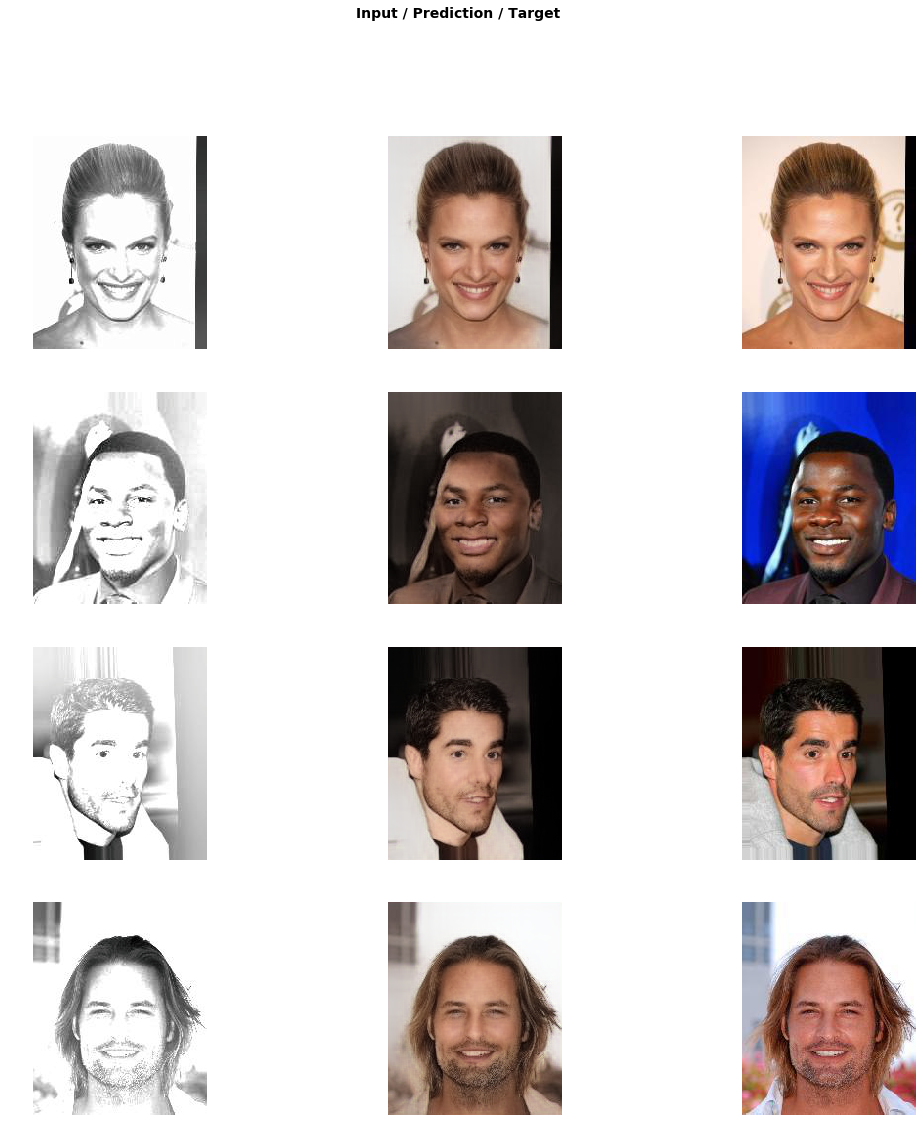

In [50]:
learn.show_results(rows=4,figsize=(18,18))